In [22]:
import pandas as pd
from langchain_community.utilities import SQLDatabase
import sqlite3
import shap
import matplotlib
from dotenv import load_dotenv
load_dotenv()

True

In [ ]:
df_1 = pd.read_csv(fr"C:\Users\AMONTORIOP002\Downloads\data\data\test_data_BankIA.csv", encoding="utf-8", sep=";")
df_1.head(3)

In [ ]:
df = pd.read_csv(fr"C:\Users\AMONTORIOP002\Downloads\data\data\training_data_BankIA.csv", encoding="utf-8", sep=";")
df.head(3)

In [ ]:
df_total= pd.concat([df,df_1], axis=0)
df_total

In [ ]:
table_name = "FOUNDATIONS"
sep = ";"
encoding = "utf-8"

conn = sqlite3.connect(fr'db/{table_name}.db')

df = df_total

df.to_sql(table_name, conn, if_exists='replace', index=False)
# Cierra la conexión
conn.close()

In [2]:
test = pd.read_csv(fr"C:\Users\AMONTORIOP002\Downloads\test1.csv")

In [3]:
import dill
with open('./model/model.pkl', 'rb') as file:
        model = dill.load(file)

c:\Users\AMONTORIOP002\Desktop\DEVOPS\gcp_aiaas\.venv\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\AMONTORIOP002\Desktop\DEVOPS\gcp_aiaas\.venv\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [4]:
model.predict(test)

array([False])

In [9]:
def generate_local_shap_values(modelo, transaccion):
    # Inicializar el explicador
    explainer = shap.TreeExplainer(modelo.model)
    
    transaccion = model.target_encode(model.drop_columns(transaccion))
    
    # Obtener los valores de SHAP para la transacción
    shap_values = explainer.shap_values(transaccion)
        
    # Seleccionar los valores SHAP para una clase (por ejemplo, clase 0 o clase 1)
    shap_values_for_class = shap_values[0][:, 0]  # Para clase 0 (ajustar si necesitas la clase 1)
    
    # Asegurarse de que transaccion es una fila individual y no un DataFrame
    transaccion_values = transaccion.iloc[0].values  # Extraemos los valores de la primera fila como numpy array

    # Obtener los nombres de las características
    feature_names = transaccion.columns.tolist()  # Obtenemos los nombres de las columnas del DataFrame
    
    # Crear el objeto Explanation con los nombres de las características
    explanation = shap.Explanation(values=shap_values_for_class, 
                                   base_values=shap_values[0][0, 0],  # Base value de la clase 0
                                   data=transaccion_values, 
                                   feature_names=feature_names)  # Agregar los nombres de las variables
    #print(shap_values)
    #print(shap_values_for_class)
    # Crear el gráfico de cascada usando el objeto Explanation
    return shap.plots.waterfall(explanation, show=True)

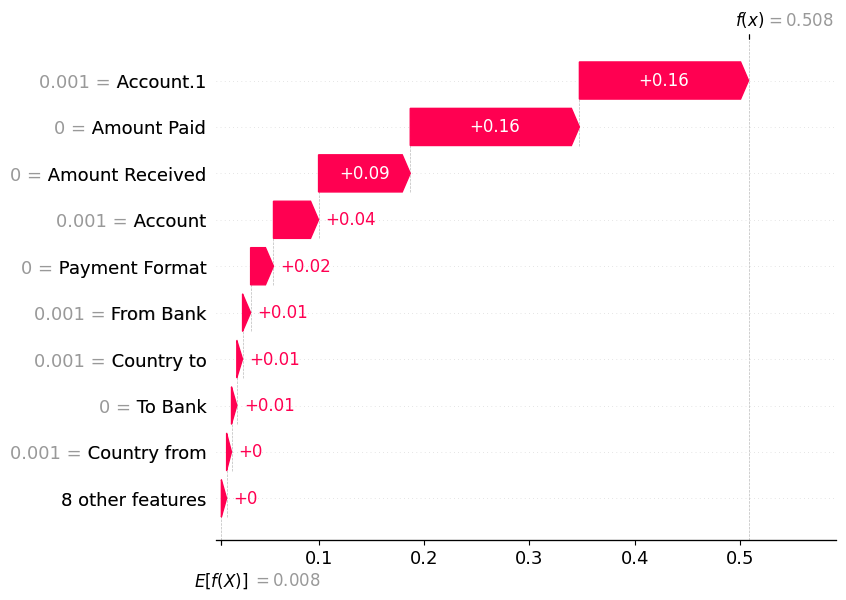

In [10]:
generate_local_shap_values(model, test)

In [15]:
import shap
import matplotlib.pyplot as plt

def generate_local_shap_values(modelo, transaccion):
    # Inicializar el explicador
    explainer = shap.TreeExplainer(modelo.model)
    
    # Transformar la transacción según el modelo
    transaccion = modelo.target_encode(modelo.drop_columns(transaccion))
    
    # Obtener los valores de SHAP para la transacción
    shap_values = explainer.shap_values(transaccion)
        
    # Seleccionar los valores SHAP para una clase (por ejemplo, clase 0)
    shap_values_for_class = shap_values[0][:, 0]  # Para clase 0 (ajusta si necesitas la clase 1)
    
    # Asegurarse de que transaccion es una fila individual
    transaccion_values = transaccion.iloc[0].values  # Extrae los valores de la primera fila como numpy array

    # Obtener los nombres de las características
    feature_names = transaccion.columns.tolist()  # Nombres de las columnas del DataFrame
    
    # Crear el objeto Explanation con los nombres de las características
    explanation = shap.Explanation(
        values=shap_values_for_class, 
        base_values=shap_values[0][0, 0],  # Base value de la clase 0
        data=transaccion_values, 
        feature_names=feature_names
    )
    
    # Crear y guardar el gráfico de cascada
    fig, ax = plt.subplots()
    shap.plots.waterfall(explanation, show=False)
    fig.savefig("shap_waterfall.png", format="png", dpi=300, bbox_inches="tight")
    plt.close(fig)  # Cerrar la figura para liberar memoria

    return "El gráfico de SHAP waterfall ha sido guardado como 'shap_waterfall.png'."


In [16]:
generate_local_shap_values(model, test)

"El gráfico de SHAP waterfall ha sido guardado como 'shap_waterfall.png'."

In [42]:
import shap
import matplotlib.pyplot as plt
from google.cloud import storage
import vertexai

def generate_and_upload_shap_waterfall(modelo, transaccion, bucket_name):
    id_transaccion = -1
    try:
        # Inicializar Vertex AI
        vertexai.init(project="single-cirrus-435319-f1")
        
        id_transaccion = transaccion.ID[0]
        # Inicializar el explicador de SHAP
        explainer = shap.TreeExplainer(modelo.model)
        
        # Transformar la transacción según el modelo
        transaccion = modelo.target_encode(modelo.drop_columns(transaccion))
        
        # Obtener los valores de SHAP para la transacción
        shap_values = explainer.shap_values(transaccion)
            
        # Seleccionar los valores SHAP para una clase (por ejemplo, clase 0)
        shap_values_for_class = shap_values[0][:, 0]  # Para clase 0 (ajusta si necesitas la clase 1)
        
        # Asegurarse de que transaccion es una fila individual
        transaccion_values = transaccion.iloc[0].values  # Extrae los valores de la primera fila como numpy array

        # Obtener los nombres de las características
        feature_names = transaccion.columns.tolist()  # Nombres de las columnas del DataFrame
        
        # Crear el objeto Explanation con los nombres de las características
        explanation = shap.Explanation(
            values=shap_values_for_class, 
            base_values=shap_values[0][0, 0],  # Base value de la clase 0
            data=transaccion_values, 
            feature_names=feature_names
        )
        
        # Crear y guardar el gráfico de cascada
        fig, ax = plt.subplots()
        shap.plots.waterfall(explanation, show=False)
        image_path = f"shap_local_{id_transaccion}.png"
        fig.savefig(image_path, format="png", dpi=300, bbox_inches="tight")
        plt.close(fig)  # Cerrar la figura para liberar memoria
        
        destination_blob_name = f"foundations/shap_local_{id_transaccion}.png"
        # Subir la imagen al bucket de Google Cloud Storage
        storage_client = storage.Client()
        bucket = storage_client.bucket(bucket_name)
        blob = bucket.blob(destination_blob_name)
        blob.upload_from_filename(image_path)

        print(f"El gráfico de SHAP waterfall ha sido guardado y subido a {destination_blob_name} en el bucket {bucket_name}.")
        return True, id_transaccion
    except Exception as e:
        print(f"Error al subir SHAP al bucket -> {e}")
        return False, id_transaccion


In [43]:
res = generate_and_upload_shap_waterfall(
    modelo=model,
    transaccion=test,
    bucket_name="single-cirrus-435319-f1-bucket"
)


El gráfico de SHAP waterfall ha sido guardado y subido a foundations/shap_local_20221001004055_1855.png en el bucket single-cirrus-435319-f1-bucket.


In [44]:
res

(True, '20221001004055_1855')